# Forecasting the closing price, Model: SARIMAX, Stock Token: CMG, Train/Test/Validation/: 70/20/10
- Dataset: 1313 rows x 7 columns (01/03/2019 - 31/05/2024) - exogenous variable: low price
----
### Model evaluation (Test set)
- RMSE: 2276.35
- MAE: 1743.86
- MAPE: 4.88 %

### Import neccesary libraries


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

plt.style.use("default")

### Define the split type and stock name


In [35]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [36]:
# Choose the split_type and stock_name -> CMG - 7 2 1
split = 0  # 7 2 1
stock = 1  # CMG

## 1.Data preprocessing


In [37]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,13590,13590,13360,13480,9850,CMG
1,2019-03-04,13550,14060,13550,13970,118020,CMG
2,2019-03-05,13830,14490,13830,14460,222050,CMG
3,2019-03-06,14460,14720,13850,14060,224770,CMG
4,2019-03-07,14340,14340,13830,13830,112670,CMG
...,...,...,...,...,...,...,...
1308,2024-05-27,60500,61100,57000,59000,2265500,CMG
1309,2024-05-28,59800,62400,59200,62100,1479800,CMG
1310,2024-05-29,62100,63400,60000,60000,2384000,CMG
1311,2024-05-30,59000,60100,58100,59200,1814100,CMG


In [38]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [39]:
df.reset_index(drop=True)
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [40]:
# Shape of the dataframe
df.shape

(1313, 2)

In [41]:
df.dtypes

low      int64
close    int64
dtype: object

In [42]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,26235.587205,26832.390708
std,9802.115234,10097.555228
min,10780.000000,10880.000000
25%,17540.000000,17810.000000
50%,27510.000000,28380.000000
75%,33440.000000,34350.000000
max,63000.000000,63600.000000


## 2. Train model


In [43]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [44]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [45]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

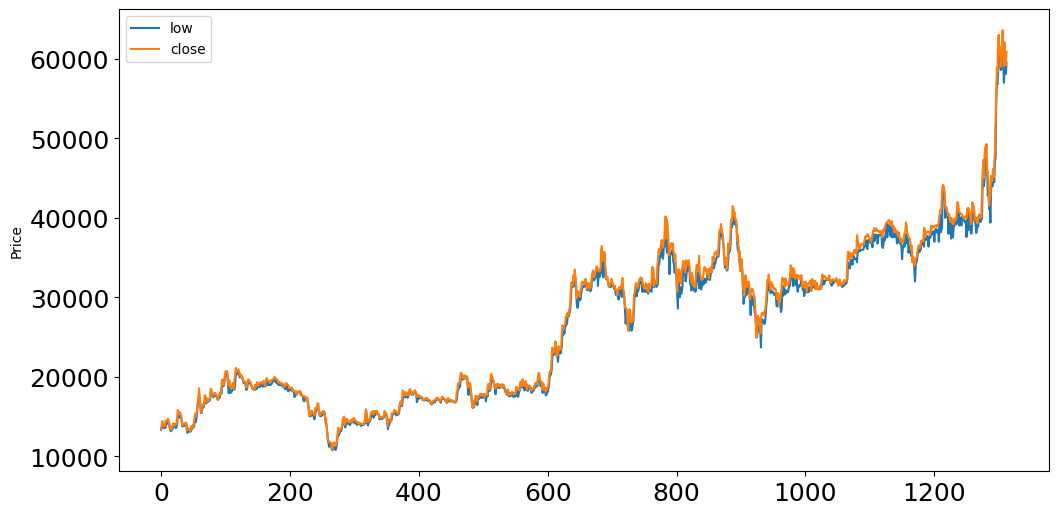

In [46]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [47]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(0.9665029450963444,
 0.9938996357719839,
 21,
 1291,
 {'1%': -3.4354254066484664,
  '5%': -2.863781366113082,
  '10%': -2.56796331977745},
 20590.753479727184)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [48]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [49]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.438
Failed to Reject Ho - Time Series is Non-Stationary
ADF Test on 'close' -> p-value: 0.571
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


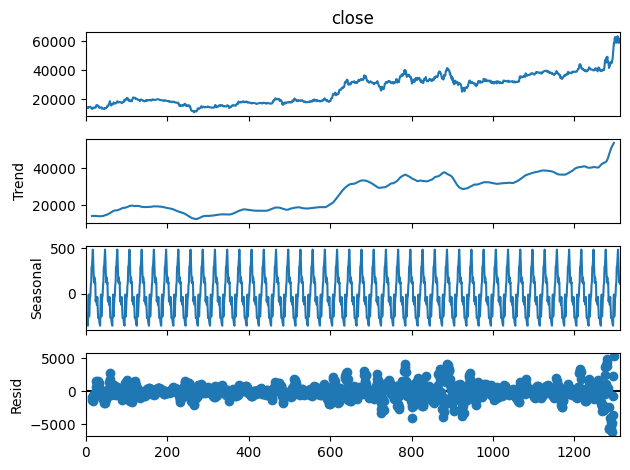

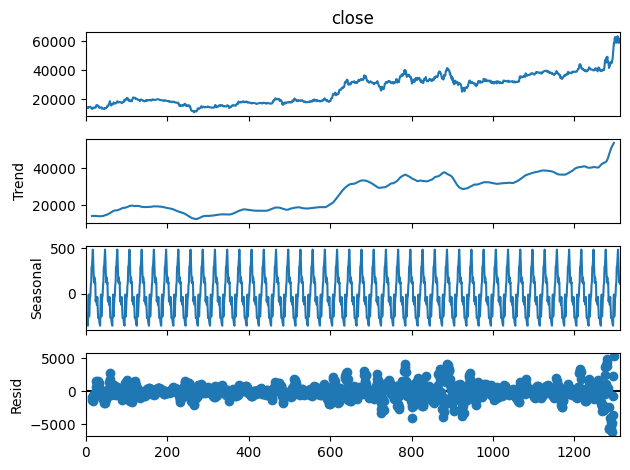

In [50]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [51]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [52]:
# Check again
adfuller(df_diff)

(-23.06833677840579,
 0.0,
 1,
 916,
 {'1%': -3.4375090829661534,
  '5%': -2.864700447588469,
  '10%': -2.5684528237924527},
 14059.177727416965)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

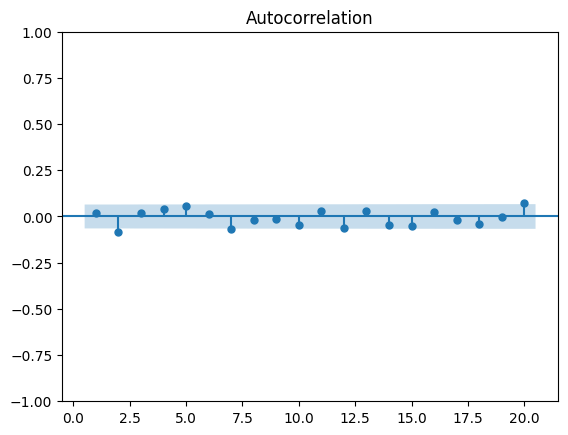

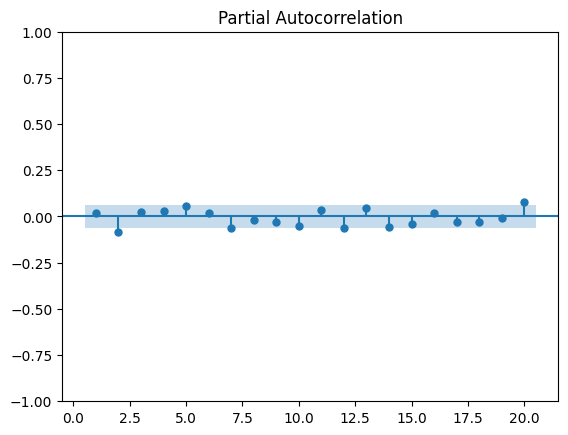

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [54]:
# Review the dataset again
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [55]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=14393.492, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=14394.229, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=14393.916, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=14392.381, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=14392.532, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=14392.253, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=14393.860, Time=0.12 sec
 ARIMA(0,1,0)(0,0,2)[5] intercept   : AIC=14393.059, Time=0.07 sec
 ARIMA(0,1,0)(1,0,2)[5] intercept   : AIC=14394.679, Time=0.17 sec
 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=14393.959, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=14394.016, Time=0.16 sec
 ARIMA(0,1,0)(0,0,1)[5]             : AIC=14391.016, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[5]             : AIC=14392.658, Time=0.13 sec
 ARIMA(0,1,0)(0,0,2)[5]  

In [56]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  919
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood               -7193.508
Date:                             Mon, 03 Jun 2024   AIC                          14391.016
Time:                                     21:21:38   BIC                          14400.660
Sample:                                          0   HQIC                         14394.697
                                             - 919                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L5        0.0620      0.022      2.773      0.006       0.018       0.106
sigma2      3.748e+05   1.0

#### Use SARIMAX to train model


In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(0, 1, 0),
    seasonal_order=(0, 0, 1, 5),
)

model_fit = model1.fit()

### Test


In [58]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([30666.41768598, 30986.50953475, 30253.73733524, 30249.63487526,
       29621.79715451, 28734.15567284, 28771.92765078, 29475.43073998,
       29126.039944  , 29697.3411104 , 29012.72401017, 28974.95203223,
       28143.96851747, 29843.70752493, 29697.3411104 , 29772.88506629,
       29735.11308834, 29550.97469587, 29550.97469587, 29938.13746979,
       30471.66665824, 30896.60141011, 31434.8520958 , 31987.26727323,
       31543.44653239, 31987.26727323, 31618.99048828, 31359.30813992,
       31562.33252136, 31505.67455445, 31467.9025765 , 31359.30813992,
       31359.30813992, 31250.71370333, 31359.30813992, 31302.650173  ,
       30622.75457002, 30584.98259207, 31080.73980258, 31283.76418403,
       30584.98259207, 30622.75457002, 30806.89296249, 30249.75628782,
       30433.8946803 , 31359.30813992, 31212.94172538, 31803.12888075,
       31618.99048828, 31283.76418403, 31543.44653239, 31359.30813992,
       31467.9025765 , 31505.67455445, 31434.8520958 , 31656.76246622,
      

#### Validate


In [59]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([34344.46403823, 34329.32958276, 34356.71843936, 34130.70560896,
       35056.24048114, 34650.19171825, 34517.98979545, 34702.12818792,
       34758.78615484, 34758.78615484, 34130.82702153, 34683.24219895,
       34650.19171825, 34678.52070171, 35009.02550872, 34843.77310521,
       34914.59556386, 35032.63299493, 35032.63299493, 34418.83835335,
       35056.24048114, 35174.27791222, 35174.27791222, 34961.81053629,
       35032.63299493, 35127.06293979, 34418.83835335, 35622.8201503 ,
       36024.14741595, 34985.4180225 , 35127.06293979, 35268.70785708,
       37487.81156126, 37535.02653369, 37487.81156126, 37157.30675426,
       35835.28752623, 36236.61479188, 36236.61479188, 35976.93244352,
       35858.89501245, 34890.98807764, 35693.64260894, 35764.46506759,
       35599.21266408, 34607.69824306, 35670.03512273, 35339.53031572,
       34678.52070171, 35315.92282951, 35363.13780194, 35599.21266408,
       35457.5677468 , 35457.5677468 , 35504.78271922, 36000.53992973,
      

### Predict the next 30/60/90 days


In [60]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [61]:
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [62]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[36806.53263908 36802.5292192  36822.16312242 36829.19169802
 36840.44414617 36851.57518176 36862.70621735 36873.83725294
 36884.96828852 36896.09932411 36907.2303597  36918.36139529
 36929.49243087 36940.62346646 36951.75450205 36962.88553764
 36974.01657322 36985.14760881 36996.2786444  37007.40967998
 37018.54071557 37029.67175116 37040.80278675 37051.93382233
 37063.06485792 37074.19589351 37085.3269291  37096.45796468
 37107.58900027 37118.72003586]


### Plotting the data


In [68]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(16, 9))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"The next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Forecasting Using SARIMAX")
    plt.legend()
    plt.show()

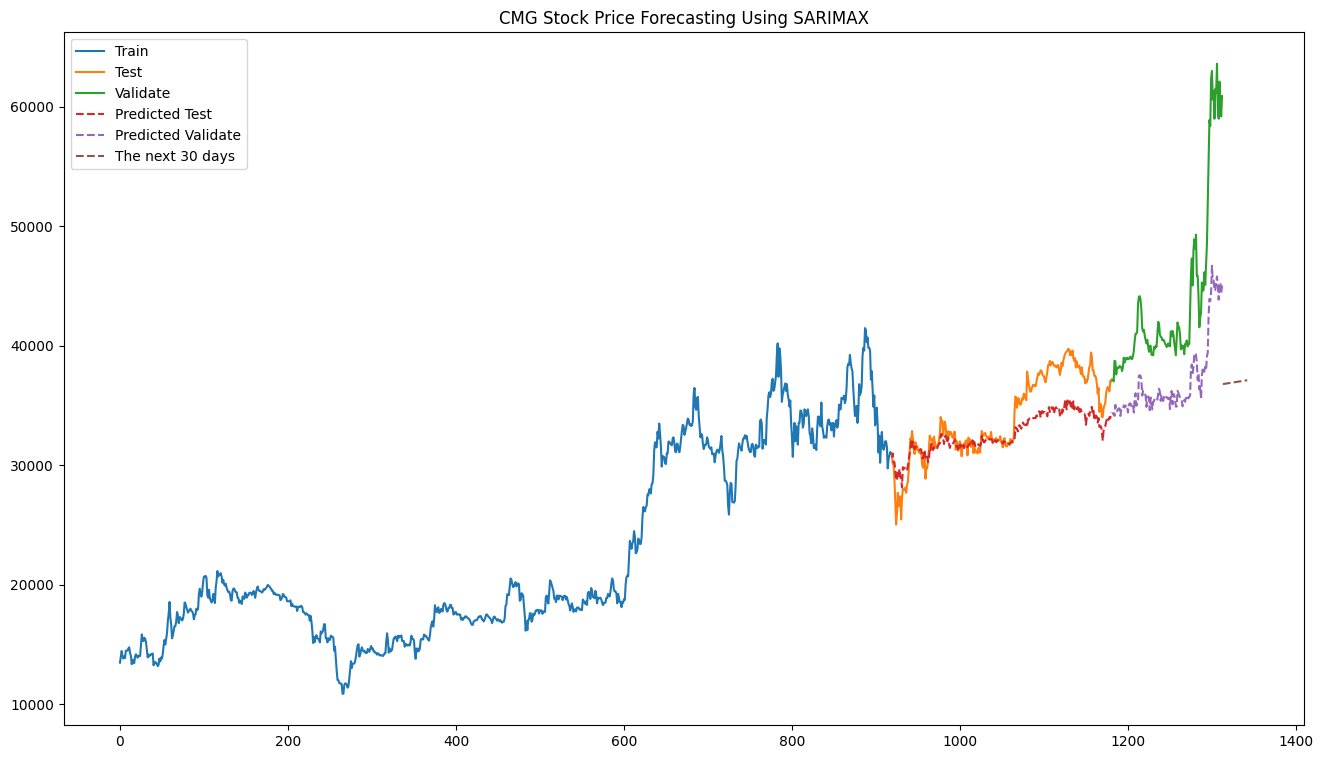

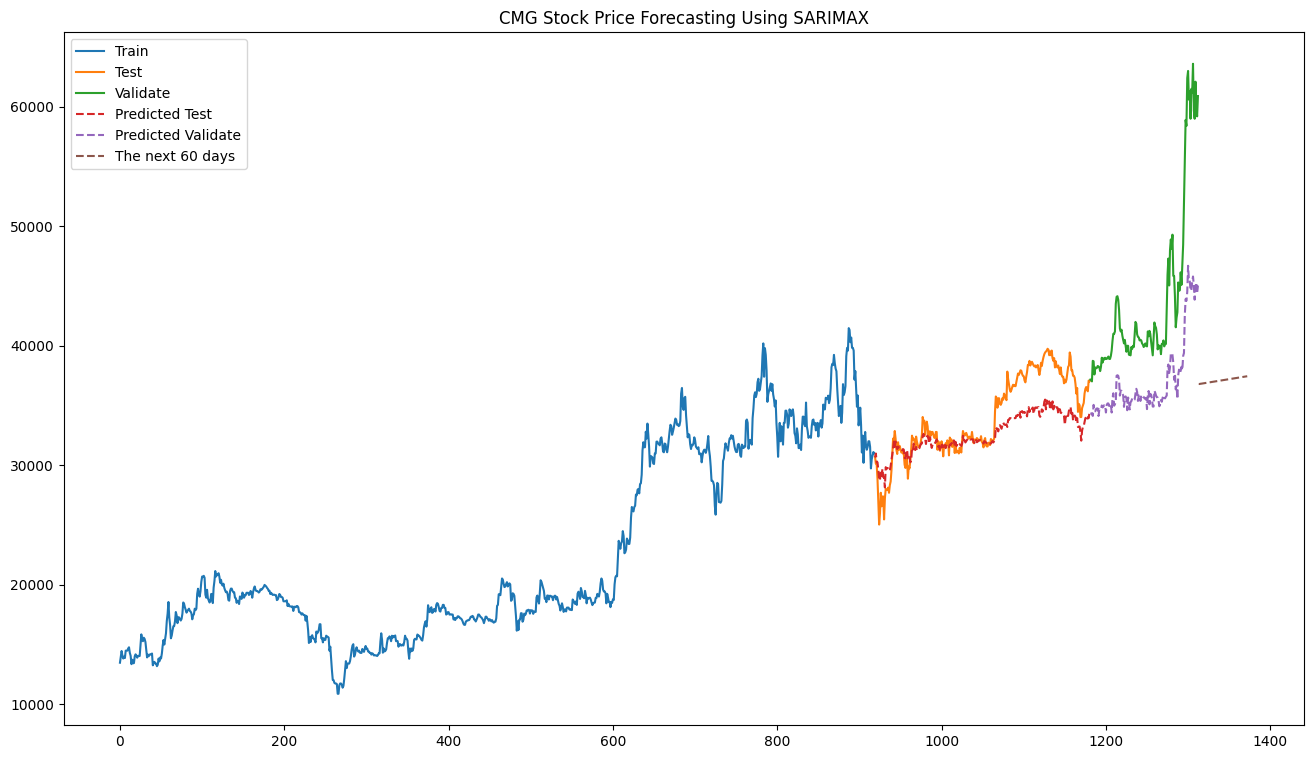

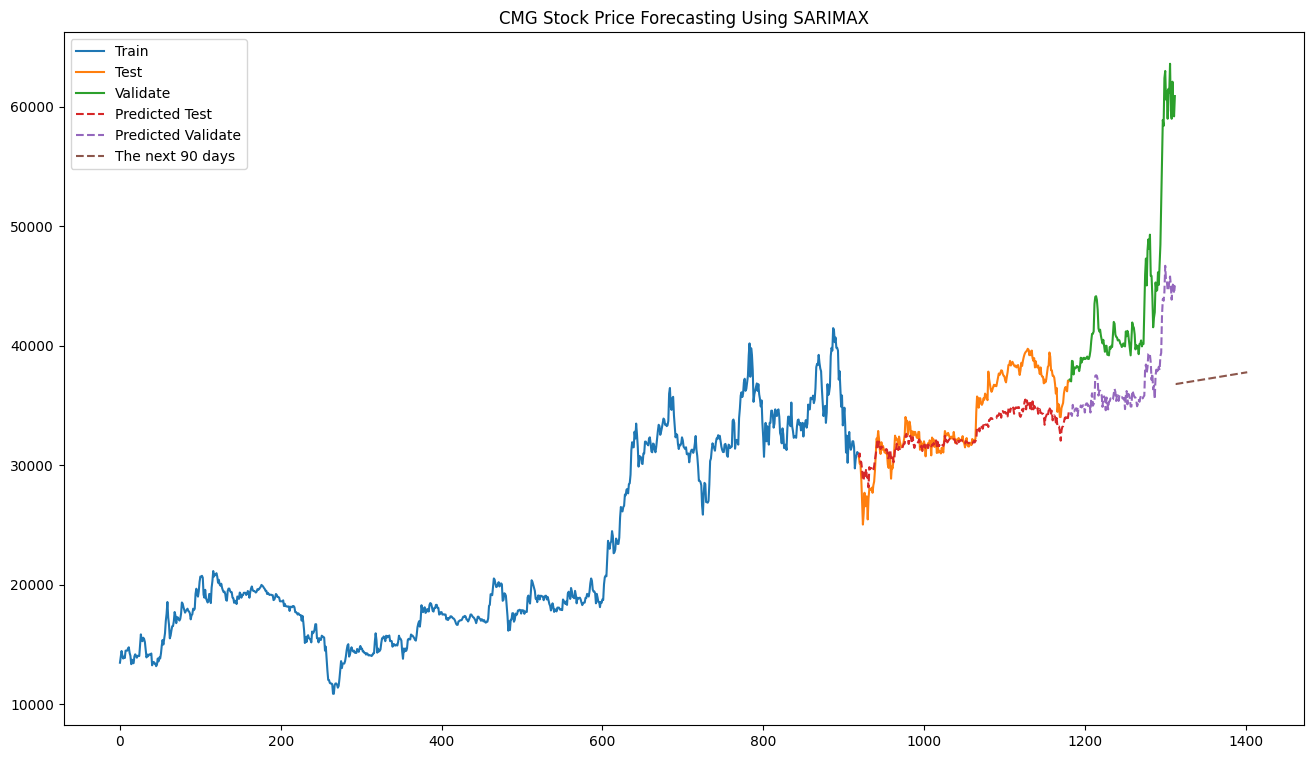

In [69]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [65]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 2276.346399841822
MAE on test data: 1743.86457564476
MAPE on test data: 4.876849201669485 %


In [66]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 7629.742471771178
MAE on validation data: 6592.288796542537
MAPE on validation data: 14.282291163931193 %
